<b>Objective</b></br>
To build a regression model that predicts the total amount for each trip.

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

from scipy import stats #shapiro - Normality, boxcox - transformation

import statsmodels.api as sm #OLS, QQPLOT - Normality

import statsmodels.stats.api as sms  #heteroskedasticity

from statsmodels.stats.stattools import durbin_watson # autocorrelation

from statsmodels.stats.outliers_influence import variance_inflation_factor # multicollinearity

from sklearn.linear_model import LinearRegression # Linear regression model
from sklearn.linear_model import SGDRegressor # Stochastic gradient descent
from sklearn.linear_model import Ridge # ridge regularization
from sklearn.linear_model import Lasso # lasso regualrization
from sklearn.linear_model import ElasticNet # elasticnet regularization

from sklearn.model_selection import train_test_split # train_test_split
from sklearn.model_selection import KFold # Kfold
from sklearn.model_selection import cross_val_score # kfold similar
from sklearn.model_selection import LeaveOneOut # LOOCV
from sklearn.model_selection import GridSearchCV # GridsearchCV

from sklearn.metrics import mean_squared_error # performance measure
from sklearn.metrics import mean_absolute_error # performance measure
from sklearn.metrics import r2_score # performance measure
from sklearn.metrics import mean_absolute_percentage_error # performance measure

from mlxtend.feature_selection import SequentialFeatureSelector as sfs # feature selection
from sklearn.feature_selection import RFE # RFE feature selection

from sklearn.preprocessing import StandardScaler #feature scaling
from sklearn.preprocessing import MinMaxScaler #feature scaling
from sklearn.preprocessing import LabelEncoder #Label encoding
from sklearn.preprocessing import OrdinalEncoder #Ordinal encoding

from category_encoders import TargetEncoder # target encoding

from sklearn.neighbors import KNeighborsRegressor  # Import KNN Regressor
from sklearn.tree import DecisionTreeRegressor     # Import Decision Tree Regressor - include max_depth
from sklearn.ensemble import RandomForestRegressor # Import Random Forest Regressor - include n_estimators and max_depth
from sklearn.ensemble import AdaBoostRegressor     # Import AdaBoost Regressor
from sklearn.ensemble import GradientBoostingRegressor # Import Gradient Boosting Regressor
from xgboost import XGBRegressor # Import XGB Regressor

In [2]:
# import the cleaned dataset
df = pd.read_csv('cleaned_taxi_dataset.csv')

df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_secs,pickup_date,dropoff_date,pickup_hour,drop_hour,pickup_day,dropoff_day
0,2,2023-04-03 16:00:05,2023-04-03 16:10:40,1,1.41,1.0,N,162,137,2,11.4,0.0,0.5,0.0,0.0,1.0,15.4,2.5,0.0,Manhattan,Midtown East,Yellow Zone,Manhattan,Kips Bay,Yellow Zone,635.0,2023-04-03,2023-04-03,16,16,Monday,Monday
1,2,2023-04-03 16:44:51,2023-04-03 16:49:59,1,0.78,1.0,N,43,230,2,6.5,0.0,0.5,0.0,0.0,1.0,10.5,2.5,0.0,Manhattan,Central Park,Yellow Zone,Manhattan,Times Sq/Theatre District,Yellow Zone,308.0,2023-04-03,2023-04-03,16,16,Monday,Monday
2,2,2023-04-03 16:00:26,2023-04-03 16:14:36,1,1.89,1.0,N,75,237,2,14.9,0.0,0.5,0.0,0.0,1.0,18.9,2.5,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,Upper East Side South,Yellow Zone,850.0,2023-04-03,2023-04-03,16,16,Monday,Monday
3,2,2023-04-03 16:00:13,2023-04-03 16:09:27,5,2.00,1.0,N,238,166,1,11.4,0.0,0.5,1.0,0.0,1.0,16.4,2.5,0.0,Manhattan,Upper West Side North,Yellow Zone,Manhattan,Morningside Heights,Boro Zone,554.0,2023-04-03,2023-04-03,16,16,Monday,Monday
4,2,2023-04-03 16:01:17,2023-04-03 16:14:46,1,2.19,1.0,N,229,234,1,14.2,0.0,0.5,1.0,0.0,1.0,19.2,2.5,0.0,Manhattan,Sutton Place/Turtle Bay North,Yellow Zone,Manhattan,Union Sq,Yellow Zone,809.0,2023-04-03,2023-04-03,16,16,Monday,Monday


In [4]:
# dataframe shape
df.shape

(132015, 32)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132015 entries, 0 to 132014
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               132015 non-null  int64  
 1   tpep_pickup_datetime   132015 non-null  object 
 2   tpep_dropoff_datetime  132015 non-null  object 
 3   passenger_count        132015 non-null  int64  
 4   trip_distance          132015 non-null  float64
 5   RatecodeID             132015 non-null  float64
 6   store_and_fwd_flag     132015 non-null  object 
 7   PULocationID           132015 non-null  int64  
 8   DOLocationID           132015 non-null  int64  
 9   payment_type           132015 non-null  int64  
 10  fare_amount            132015 non-null  float64
 11  extra                  132015 non-null  float64
 12  mta_tax                132015 non-null  float64
 13  tip_amount             132015 non-null  float64
 14  tolls_amount           132015 non-nu

In [3]:
# date time dtype conversion
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [4]:
# create a new feature "pickup_minutes"
df['pickup_mins'] = df['tpep_pickup_datetime'].dt.minute

<b>Linear Regression Models with all features</b>

In [5]:
# create a copy of the dataframe
df1 = df.copy()

In [6]:
# as it can be seen from the five point summary, mta_tax and improvement surcharge has zero standard deviation. 
# Hence, it can be removed.

df1.drop(columns = ['mta_tax', 'improvement_surcharge'], inplace  = True )

In [7]:
# removing pickup dates and dropoff dates from the dataframe
df1.drop(columns = ['pickup_date', 'dropoff_date', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace = True)

In [8]:
# dropping other additional columns
df1.drop(columns = ['PU_Borough', 'PU_Zone', 'PU_service_zone', 'DO_Borough', 'DO_Zone', 'DO_service_zone', 'dropoff_day'], inplace = True)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132015 entries, 0 to 132014
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   VendorID              132015 non-null  int64  
 1   passenger_count       132015 non-null  int64  
 2   trip_distance         132015 non-null  float64
 3   RatecodeID            132015 non-null  float64
 4   store_and_fwd_flag    132015 non-null  object 
 5   PULocationID          132015 non-null  int64  
 6   DOLocationID          132015 non-null  int64  
 7   payment_type          132015 non-null  int64  
 8   fare_amount           132015 non-null  float64
 9   extra                 132015 non-null  float64
 10  tip_amount            132015 non-null  float64
 11  tolls_amount          132015 non-null  float64
 12  total_amount          132015 non-null  float64
 13  congestion_surcharge  132015 non-null  float64
 14  Airport_fee           132015 non-null  float64
 15  

In [10]:
# Dtype conversion
df1['VendorID'] = df1['VendorID'].astype(object)
df1['passenger_count'] = df1['passenger_count'].astype(object)
df1['RatecodeID'] = df1['RatecodeID'].astype(object)
df1['payment_type'] = df1['payment_type'].astype(object)
df1['pickup_hour'] = df1['pickup_hour'].astype(object)
df1['drop_hour'] = df1['drop_hour'].astype(object)

In [11]:
# split target and predictor variables
df_target = df1['total_amount']
df_ivs = df1.drop('total_amount',axis=1)

In [12]:
# columns of predictor variables
df_ivs.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'tip_amount', 'tolls_amount',
       'congestion_surcharge', 'Airport_fee', 'trip_duration_secs',
       'pickup_hour', 'drop_hour', 'pickup_day', 'pickup_mins'],
      dtype='object')

In [13]:
# create separate dataframes for numeric and categoric variables
df_numeric = df_ivs.select_dtypes(np.number).drop(columns=['PULocationID', 'DOLocationID','pickup_mins'])
df_cat = df_ivs.select_dtypes(exclude=np.number)

# creating another copy of categoric variables; for now, these will not be encoded
df_cat1 = df_ivs[['PULocationID', 'DOLocationID','pickup_mins']] 

In [14]:
# scaling and encoding of numeric and categoric variables
df_num_scaled = df_numeric.apply(stats.zscore) # standard scaling
df_cat_enc = pd.get_dummies(df_cat, drop_first=True) # onehot encoding

In [15]:
# concat the final df for building the linear models
df_ivs = pd.concat([df_num_scaled, df_cat_enc, df_cat1], axis=1)

<b> LR Variant 1 </b></br>
Independent variables - scaled and one hot encoded; Target variable - no changes

In [16]:
# dropping the attributes with high vif to remove multicorrelation

df_ivs_copy = df_ivs.copy()
while True:
    vif_factor = [variance_inflation_factor(df_ivs_copy.values, i) for i in range(len(df_ivs_copy.columns))]
    vif_features = df_ivs_copy.columns
    vif = pd.DataFrame({'vif_factor': vif_factor, 'vif_features':vif_features})
    if vif['vif_factor'].max() > 5:
        df_ivs_copy.drop(vif['vif_features'][vif['vif_factor'] == vif['vif_factor'].max()], axis=1, inplace=True)
    else:
        break

vif.sort_values(by='vif_factor',ascending=False)

,vif_factor,vif_features
24,3.828806,drop_hour_18
21,3.595322,pickup_hour_18
20,3.455302,pickup_hour_17
31,3.374404,pickup_mins
6,3.279300,VendorID_2
23,3.255491,drop_hour_17
4,3.134549,Airport_fee
2,2.989014,tolls_amount
0,2.554711,extra
5,2.283422,trip_duration_secs


In [24]:
# shape of the dataframe
df_ivs_copy.shape

(132015, 32)

In [17]:
# split train and test data using the selected variables after VIF

X= df_ivs_copy
y= df_target

# adding constant to the predictor
X = sm.add_constant(X)

# train_test_splitting 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state=0)

# checking the dimensions of the train & test subset
# print dimension of train set
print('X_train_full', X_train.shape)
print('y_train_full', y_train.shape)

# print dimension of test set
print('X_test_full', X_test.shape)
print('y_test_full', y_test.shape)

X_train_full (92410, 33)
y_train_full (92410,)
X_test_full (39605, 33)
y_test_full (39605,)


In [18]:
# base LR model summary
model1 = sm.OLS(y_train, X_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 6.831e+04
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:50:34   Log-Likelihood:            -2.6288e+05
No. Observations:               92410   AIC:                         5.258e+05
Df Residuals:                   92377   BIC:                         5.261e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   27.4719 

In [28]:
# filter the number of variables which has p-value greater than 0.5
(model1.pvalues>0.05).sum()

7

In [ ]:
# 7 variables found to be insignificant in the first base model

In [ ]:
### Assumptions before:
# 1. target variable numerical - Satisfied
# 2. No multicolinearity - Not Satisfied (Even though the VIF gave values less than 5, multicollinearity exists as Condition 
# number is greater thatn 100)

### Assumptions after:
# 3. No autocorrelation - Satisfied (As durbin-watson is giving a value of nearly 2)
# 4. Normality among residuals - Not satisfied (As the probability of JB is 0 which is less than the alpha value of 0.05)
# (The other assumptions will be checked after building the final model)


In [ ]:
# Since the assumptions did not satisfy for the variant 1. Lets try by transforming the target variable.

<b> LR Variant 2 </b></br>
Independent variables - scaled and target encoded location IDs; Target variable - Transformed

In [33]:
# create a copy of the target variable
df_target = df1['total_amount']

In [30]:
# transforming the target column
print('Skewness box_cox_trans:', stats.skew(stats.boxcox(df_target)[0]))
print('Skewness sqrt_trans:', stats.skew(np.sqrt(df_target)))
print('Skewness log_trans:', stats.skew(np.log(df_target)))
print('Skewness reciprocal trans:', stats.skew(1/df_target))
print('Skewness cbrt_trans:', stats.skew(np.cbrt(df_target)))

Skewness box_cox_trans: 0.06802662904837349
Skewness sqrt_trans: 1.865173544772445
Skewness log_trans: 1.2167647056549014
Skewness reciprocal trans: 0.04458824987085358
Skewness cbrt_trans: 1.6500268056830625


In [34]:
# The best value of skewness is given by reciprocal transformation, thus we will use box_cox
df_target = 1/df_target

In [35]:
# split the train and test data
X= df_ivs
y= df_target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state=0)

In [36]:
# split the categoric and numeric variables of train and test data
X_train_cat = X_train[['PULocationID', 'DOLocationID', 'pickup_mins']]
X_train_num = X_train.drop(['PULocationID', 'DOLocationID', 'pickup_mins'], axis=1)

X_test_cat = X_test[['PULocationID', 'DOLocationID', 'pickup_mins']]
X_test_num = X_test.drop(['PULocationID', 'DOLocationID', 'pickup_mins'], axis=1)

In [37]:
# target encoding  of the chosen features
cat_cols = X_train_cat.columns
encoder = TargetEncoder(cols=cat_cols)

X_train_enc = encoder.fit_transform(X_train_cat, y_train)
X_test_enc = encoder.fit_transform(X_test_cat, y_test)

In [38]:
X_train_enc = pd.concat([X_train_enc, X_train_num], axis=1)
X_test_enc = pd.concat([X_test_enc, X_test_num], axis=1)

In [39]:
# variance inflation factor check for multicollinearity

X_train_enc_vif = X_train_enc.copy()
while True:
    vif_factor = [variance_inflation_factor(X_train_enc_vif.values, i) for i in range(len(X_train_enc_vif.columns))]
    vif_features = X_train_enc_vif.columns
    vif = pd.DataFrame({'vif_factor': vif_factor, 'vif_features':vif_features})
    if vif['vif_factor'].max() > 5:
        X_train_enc_vif.drop(vif['vif_features'][vif['vif_factor'] == vif['vif_factor'].max()], axis=1, inplace=True)
        
    else:
        break

vif.sort_values(by='vif_factor',ascending=False)

,vif_factor,vif_features
24,3.830519,drop_hour_18
21,3.590841,pickup_hour_18
20,3.437534,pickup_hour_17
23,3.207883,drop_hour_17
4,3.136580,Airport_fee
6,3.100420,VendorID_2
2,2.999554,tolls_amount
0,2.549511,extra
5,2.260371,trip_duration_secs
1,2.240384,tip_amount


In [40]:
X_train_enc_vif.shape

(92410, 31)

In [41]:
X_test_enc_vif = X_test_enc[X_train_enc_vif.columns]

In [42]:
# adding constant to the train and test data
X_train_ = sm.add_constant(X_train_enc_vif)
X_test_ = sm.add_constant(X_test_enc[X_train_enc_vif.columns])

In [43]:
# base lR model summary
model2 = sm.OLS(y_train, X_train_).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     9507.
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:26:52   Log-Likelihood:             3.0666e+05
No. Observations:               92410   AIC:                        -6.133e+05
Df Residuals:                   92378   BIC:                        -6.130e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0445 

In [44]:
# There are insignificant columns present in the model
print('The insignificant columns are: ', model2.pvalues[model2.pvalues>0.05].index)

The insignificant columns are:  Index(['passenger_count_5', 'passenger_count_6', 'RatecodeID_4.0',
       'store_and_fwd_flag_Y', 'pickup_day_Thursday', 'pickup_day_Tuesday'],
      dtype='object')


In [45]:
# model after removing the insignificant columns ##
X_train_enc_vif = X_train_enc_vif.drop(['passenger_count_5', 'passenger_count_6', 'RatecodeID_4.0', 'store_and_fwd_flag_Y', 
                                        'pickup_day_Thursday', 'pickup_day_Tuesday'], axis=1)
X_test_enc_vif = X_test_enc_vif.drop(['passenger_count_5', 'passenger_count_6', 'RatecodeID_4.0', 'store_and_fwd_flag_Y', 
                                        'pickup_day_Thursday', 'pickup_day_Tuesday'], axis=1)

In [46]:
# adding the constant to train and test data
X_train_ = sm.add_constant(X_train_enc_vif)
X_test_ = sm.add_constant(X_test_enc_vif)

In [47]:
# base model 2 summary after removing the insignificant features based on p value.
model2 = sm.OLS(y_train, X_train_).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 1.179e+04
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:27:11   Log-Likelihood:             3.0666e+05
No. Observations:               92410   AIC:                        -6.133e+05
Df Residuals:                   92384   BIC:                        -6.130e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0445 

In [ ]:
## There is still moderate multicollinearity present, and JB < 0.05 => residuals are not normally distributed. 

In [ ]:
# Since the model assumptions are not satisfied, lets try again with feature selection methods

<b>LR Variant 3</b></br>
Using RFE and SFS feature selection methods

<b>Recursive Feature Elimination Method</b>

In [48]:
# recursive feature elimination 
LR = LinearRegression() # linear regression

rfe = RFE(estimator=LR, verbose=1) # RFE Model

rfe.fit(X_train_enc, y_train) # fitting the train data

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.


RFE(estimator=LinearRegression(), verbose=1)

In [49]:
# selecting the significant features based on ranking
feat_index = pd.Series(data=rfe.ranking_, index= X_train_enc.columns)

signi_feat = feat_index[feat_index==1].index

signi_feat

Index(['PULocationID', 'DOLocationID', 'pickup_mins', 'trip_distance',
       'fare_amount', 'tip_amount', 'congestion_surcharge',
       'trip_duration_secs', 'RatecodeID_2.0', 'RatecodeID_3.0',
       'RatecodeID_4.0', 'RatecodeID_5.0', 'payment_type_2', 'payment_type_3',
       'payment_type_4', 'drop_hour_20', 'drop_hour_21',
       'pickup_day_Wednesday'],
      dtype='object')

In [50]:
# model summary with selected features based on RFE method
X_train_ = sm.add_constant(X_train_enc[signi_feat])
X_test_ = sm.add_constant(X_test_enc[signi_feat])

model_rfe = sm.OLS(y_train, X_train_).fit()
print(model_rfe.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                 2.101e+04
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:27:36   Log-Likelihood:             3.1568e+05
No. Observations:               92410   AIC:                        -6.313e+05
Df Residuals:                   92391   BIC:                        -6.311e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0265 

In [ ]:
# The accuracy has improved but the condition number is high and
# probability of JB < 0.05 => residuals aren't normally distributed

<b>Forward Feature Selection Method</b>

In [51]:
#  forward sfs method
fs = sfs(estimator=LR, k_features='best', verbose=1)
sfs_forward = fs.fit(X_train_enc, y_train)

Features: 37/37

In [52]:
# printing the selected features
print(sfs_forward.k_feature_names_)

print('\nR-Squared: ', sfs_forward.k_score_)

('PULocationID', 'DOLocationID', 'pickup_mins', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration_secs', 'VendorID_2', 'passenger_count_2', 'passenger_count_3', 'passenger_count_4', 'passenger_count_5', 'RatecodeID_2.0', 'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0', 'store_and_fwd_flag_Y', 'payment_type_2', 'payment_type_3', 'payment_type_4', 'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19', 'drop_hour_17', 'drop_hour_18', 'drop_hour_19', 'drop_hour_20', 'drop_hour_21', 'pickup_day_Monday', 'pickup_day_Tuesday', 'pickup_day_Wednesday')

R-Squared:  0.80752822826428


In [53]:
# model summary with selected features based on RFE method
X_train_ = sm.add_constant(X_train_enc[list(sfs_forward.k_feature_names_)])
X_test_ = sm.add_constant(X_test_enc[list(sfs_forward.k_feature_names_)])

model_for = sm.OLS(y_train, X_train_).fit()
print(model_for.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                 1.112e+04
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:30:01   Log-Likelihood:             3.1675e+05
No. Observations:               92410   AIC:                        -6.334e+05
Df Residuals:                   92374   BIC:                        -6.331e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0306 

In [ ]:
# Similar to that of rfe high multicollinearity and residuals are not normally distributed

In [ ]:
# Since the assumptions did not meet, lets try regularisation methods.

<b>LR Variant 4</b></br>
Using Lasso Regularisation method - to eliminate insignificant features and to reduce the impact of multicollinearity.

In [54]:
# Lasso model to find the coefficients greater than 0
lasso = Lasso(alpha=0.01)
lasso_model = lasso.fit(X_train_enc, y_train)

In [55]:
# create a dataframe of features and its coefficients
pd.DataFrame(lasso_model.coef_, index=X_train_enc.columns)

,0
PULocationID,0.000000
DOLocationID,0.000000
pickup_mins,0.000000
trip_distance,-0.000000
fare_amount,-0.001687
extra,-0.000000
tip_amount,-0.000000
tolls_amount,-0.000000
congestion_surcharge,0.000000
Airport_fee,-0.000000


In [56]:
# performing gridsearch CV to find the best hyper parameter values
tuned_params = {'alpha':np.arange(0.001,0.011, 0.001)}

estimator = Lasso() #lasso base model

lasso_grid = GridSearchCV(estimator=estimator, param_grid=tuned_params, cv=10, scoring='r2')

lasso_grid.fit(X_train_enc, y_train)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ])},
             scoring='r2')

In [57]:
# printing the best parameter value of lasso model
lasso_grid.best_params_

{'alpha': 0.001}

In [58]:
# build lasso model with the best hyper paramter value
lasso= Lasso(alpha=0.001)
lasso_model = lasso.fit(X_train_enc, y_train)

In [59]:
# printing the features whose coefficiet values are not equal to 0
df_coefs = pd.DataFrame(lasso_model.coef_, index=X_train_enc.columns)
best_feat = df_coefs[df_coefs[0] != 0].index
best_feat

Index(['fare_amount', 'tip_amount', 'trip_duration_secs'], dtype='object')

In [60]:
# Rebuilding Linear Regression model based on the best features selected from Lasso
X_train_ = sm.add_constant(X_train_enc[best_feat])
X_test_ = sm.add_constant(X_test_enc[best_feat])

model_new = sm.OLS(y_train, X_train_).fit()
print(model_new.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                 8.056e+04
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:31:25   Log-Likelihood:             2.9984e+05
No. Observations:               92410   AIC:                        -5.997e+05
Df Residuals:                   92406   BIC:                        -5.996e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0449    3.1

In [83]:
# In this variant after using gridsearch cv the condition number is 5.18, which means there is no multicollinearity.
# The probability of JB < 0.05 => still residuals aren't normally distributed

In [ ]:
# To improve that, let's further transform the independeant variables and redo the same variant.

In [61]:
# create new dataframe with slected features from Lasso
df_new = df[['fare_amount', 'tip_amount', 'trip_duration_secs']]

In [ ]:
# Tranforming independent variables using best transformation method 

In [62]:
# trying different transformation techniques for fare amount
print('Skewness box_cox_trans:', stats.skew(stats.boxcox(df_new['fare_amount'])[0]))
print('Skewness sqrt_trans:', stats.skew(np.sqrt(df_new['fare_amount'])))
print('Skewness log_trans:', stats.skew(np.log(df_new['fare_amount'])))
print('Skewness reciprocal trans:', stats.skew(1/df_new['fare_amount']))
print('Skewness cbrt_trans:', stats.skew(np.cbrt(df_new['fare_amount'])))

Skewness box_cox_trans: 0.04149789871144673
Skewness sqrt_trans: 1.6353776188368694
Skewness log_trans: 0.7993073212195265
Skewness reciprocal trans: 0.7660859666263414
Skewness cbrt_trans: 1.3581272015215333


In [63]:
# box_cox gives the best skewness for fare amount
df_new['fare_amount'] = stats.boxcox(df_new['fare_amount'])[0]

In [64]:
# trying different transformation techniques for tip amount
print('Skewness box_cox_trans:', stats.skew(stats.boxcox(df_new['tip_amount']+0.01)[0]))
print('Skewness sqrt_trans:', stats.skew(np.sqrt(df_new['tip_amount'])))
print('Skewness log_trans:', stats.skew(np.log(df_new['tip_amount']+0.01)))
print('Skewness reciprocal trans:', stats.skew(1/df_new['tip_amount']+0.01))
print('Skewness cbrt_trans:', stats.skew(np.cbrt(df_new['tip_amount'])))

Skewness box_cox_trans: -0.36992839439488623
Skewness sqrt_trans: 0.09630919744322188
Skewness log_trans: -1.2142537909666757
Skewness reciprocal trans: nan
Skewness cbrt_trans: -0.6682242334175621


In [65]:
# sqrt gives the best skewness for tip amount
df_new['tip_amount'] = np.sqrt(df_new['tip_amount'])

In [66]:
# trying different transformation techniques for trip_duration_secs
print('Skewness box_cox_trans:', stats.skew(stats.boxcox(df_new['trip_duration_secs'])[0]))
print('Skewness sqrt_trans:', stats.skew(np.sqrt(df_new['trip_duration_secs'])))
print('Skewness log_trans:', stats.skew(np.log(df_new['trip_duration_secs'])))
print('Skewness reciprocal trans:', stats.skew(1/df_new['trip_duration_secs']))
print('Skewness cbrt_trans:', stats.skew(np.cbrt(df_new['trip_duration_secs'])))

Skewness box_cox_trans: -5.006780768003159e-05
Skewness sqrt_trans: 1.1006870709627785
Skewness log_trans: 0.013418649524421402
Skewness reciprocal trans: 2.8448642025552564
Skewness cbrt_trans: 0.7343567367227894


In [67]:
# box_cox gives the best skewness for trip_duration_secs
df['trip_duration_secs'] = stats.boxcox(df_new['trip_duration_secs'])[0]

In [68]:
# scaling the transformed data
df_new_scaled = df_new.apply(stats.zscore)

In [69]:
# split train and test data
X_new = df_new_scaled.copy()
X_new_ = sm.add_constant(X_new)
y = df_target

X_train_best, X_test_best, y_train, y_test = train_test_split(X_new_,y,test_size = 0.3, random_state=0)

In [70]:
# Rebuilding LR model after transformation of independent variables using lasso gcv features 
model_transformed = sm.OLS(y_train, X_train_best).fit()
print(model_transformed.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 8.301e+05
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:32:33   Log-Likelihood:             3.9434e+05
No. Observations:               92410   AIC:                        -7.887e+05
Df Residuals:                   92406   BIC:                        -7.886e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0449   1.12

In [ ]:
# NOTE: the r2 and adj_r2 scores have significantly improved. 

# Assumptions before model building:
# 1. target variable numerical - Satisfied
# 2. No multicolinearity - Satisfied (Condition number < 100)

### Assumptions after:
# 3. No autocorrelation - Satisfied (As durbin-watson is giving a value of nearly 2)
# 4. Normality amond residuals - Not satisfied (As the probability of JB is 0 which is less than the alpha value of 0.05)
# 5. No Heteroscedasticity - Not satisfied (Proved in the following cells)
# 6. Linear relationship between fitted and residuals - Not satisfied (Proved in the following cells)

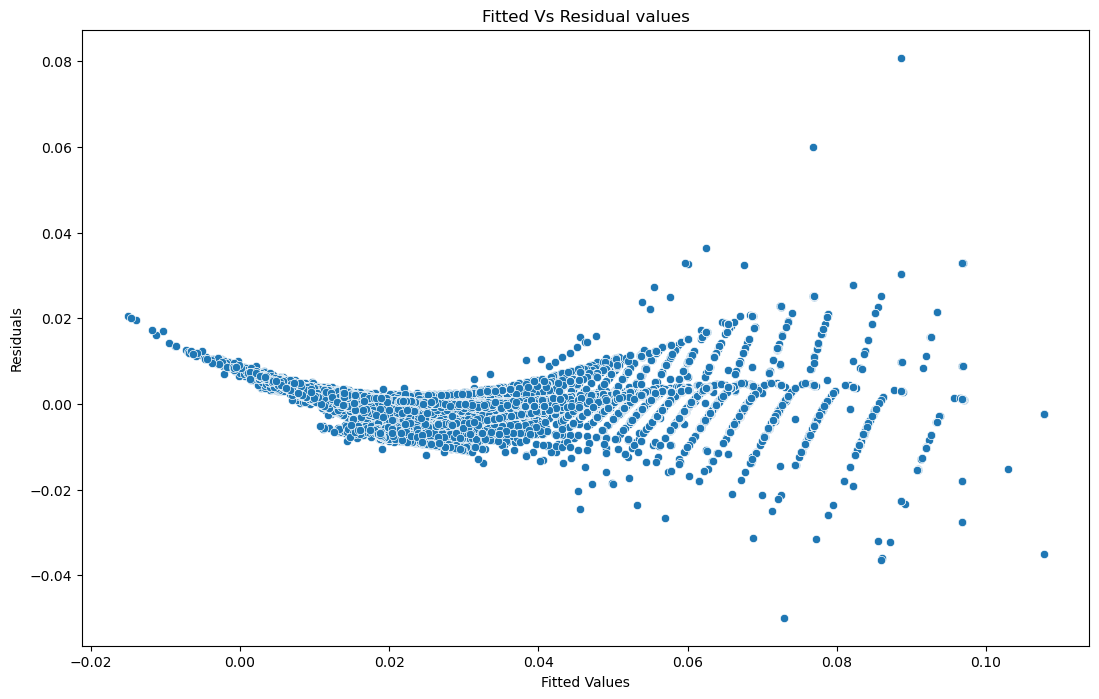

In [71]:
# Assumption 6 : Linear relationship between fitted and residuals
plt.figure(figsize = (13,8))
sns.scatterplot(x = model_transformed.fittedvalues, y = model_transformed.resid)
plt.title('Fitted Vs Residual values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [ ]:
# the above plot confirms that there is no linear relationship between fitted and residual values.
# Assumption is not satisfied.

In [72]:
# Assumption 5: No Heteroscedasticity

Ho = 'Homoskedasticity is present'
Ha = 'Heteroskedasticity is present'

hprob = sms.het_breuschpagan(resid = model_transformed.resid, exog_het = model_transformed.model.exog, robust = True)

if hprob[3] < 0.5:
    print(f'Rejecting null Hypothesis. Thus, {Ha}')
else:
    print(f'Failing to reject null hypothesis. Thus, {Ho}')

Rejecting null Hypothesis. Thus, Heteroskedasticity is present


In [ ]:
# Conclusion: After trying multiple methods, it can be confirmed that there is no linear relationship. 
# Hence, non-linear models should be done further.

<b>NON LINEAR MODEL BUILDING WITH ALL THE VARIABLES</b>

In [119]:
# create a copy of the dataframe
df2=df.copy()

In [120]:
# dropping columns which provides redundant information to the model and features with no variance

df2.drop(columns=['pickup_date','dropoff_date','tpep_pickup_datetime','tpep_dropoff_datetime', 'PU_Zone', 'PU_service_zone', 
                  'DO_Zone','DO_service_zone', 'VendorID', 'mta_tax', 'improvement_surcharge', 'dropoff_day', 
                  'fare_amount', 'PU_Borough', 'DO_Borough', 'drop_hour'],inplace=True)

In [121]:
df3 = df2.copy()

In [122]:
# create a function for preprocessing of numeric and categoric variables
def preprocessing_df1(data,y):
    ss=StandardScaler()
    numeric_ind = data.select_dtypes(include='number').drop(columns=['RatecodeID','PULocationID','DOLocationID','pickup_mins',
                                                                     'pickup_hour', 'passenger_count', 'payment_type']) 
    scaled = ss.fit_transform(numeric_ind)
    scaled_num = pd.DataFrame(scaled,columns=numeric_ind.columns)

    
    TE= TargetEncoder(cols=['PULocationID','DOLocationID','pickup_mins'])
    tencod = TE.fit_transform(data[['PULocationID','DOLocationID', 'pickup_mins']],y).reset_index(drop=True)

    
    ohe = pd.get_dummies((data[['RatecodeID', 'pickup_day', 'pickup_hour', 'passenger_count', 'store_and_fwd_flag', 
                                'payment_type']]).astype('object'),drop_first=True).reset_index(drop=True) 
    cat = pd.concat([tencod,ohe],axis=1)


    finaldf = pd.concat([scaled_num,cat],axis=1)

    
    return finaldf

In [123]:
# split target and indepdent variables
X= df2.drop(columns=['total_amount'])
y= df2.total_amount

# split train and test data
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=1)

In [124]:
# preprocessing of train and test data
Xtrain = preprocessing_df1(Xtrain,ytrain)
Xtest = preprocessing_df1(Xtest,ytest)

In [125]:
# create a fucntion for reviewing the scores of each model
score_card = pd.DataFrame(columns=['MODEL','DATA','R2','MAE','MSE','RMSE','MAPE'])

def model_performance(model,yact,xtest,data,mname):
      
    predicted = model.predict(xtest)
    MAE = mean_absolute_error(yact,predicted)
    MSE = mean_squared_error(yact,predicted)
    RMSE = np.sqrt(mean_squared_error(yact,predicted))
    R2 = r2_score(yact,predicted)
    MAPE = mean_absolute_percentage_error(yact,predicted)
    global score_card
    score_card = pd.concat([score_card,pd.DataFrame({'MODEL':[mname],'DATA':[data],'R2':[R2],'MAE': [MAE], 'MSE':[MSE],'RMSE':[RMSE],'MAPE':[MAPE]})],ignore_index=True)

In [126]:
# Instantiating different Non-Linear Regression models
#KNN
knr = KNeighborsRegressor(n_neighbors = 3)
knr.fit(Xtrain,ytrain)
model_performance(knr,ytrain,Xtrain,'TRAIN','K-NEAREST REGRESSOR')
model_performance(knr,ytest,Xtest,'TEST','K-NEAREST REGRESSOR')

#DECISION TREE
DTR = DecisionTreeRegressor(max_depth = 5)
DTR.fit(Xtrain,ytrain)
model_performance(DTR,ytrain,Xtrain,'TRAIN','DECISION TREE REGRESSOR')
model_performance(DTR,ytest,Xtest,'TEST','DECISION TREE REGRESSOR')

#RANDOM FOREST
rfr = RandomForestRegressor()
rfr.fit(Xtrain,ytrain)
model_performance(rfr,ytrain,Xtrain,'TRAIN','RANDOM FOREST REGRESSOR')
model_performance(rfr,ytest,Xtest,'TEST','RANDOM FOREST REGRESSOR')

#ADA BOOST
abr = AdaBoostRegressor()
abr.fit(Xtrain,ytrain)
model_performance(abr,ytrain,Xtrain,'TRAIN','ADA BOOST REGRESSOR')
model_performance(abr,ytest,Xtest,'TEST','ADA BOOST REGRESSOR')

#GRADIENT BOOST
GB = GradientBoostingRegressor()
GB.fit(Xtrain,ytrain)
model_performance(GB,ytrain,Xtrain,'TRAIN','GRADIENT BOOST REGRESSOR')
model_performance(GB,ytest,Xtest,'TEST','GRADIENT BOOST REGRESSOR')

#XGBOOST
xg = XGBRegressor()
xg.fit(Xtrain,ytrain)
model_performance(xg,ytrain,Xtrain,'TRAIN','XGBOOST REGRESSOR')
model_performance(xg,ytest,Xtest,'TEST','XGBOOST REGRESSOR')

In [127]:
# print scores for different models to compare the accuracy
score_card

,MODEL,DATA,R2,MAE,MSE,RMSE,MAPE
0,K-NEAREST REGRESSOR,TRAIN,0.986768,1.341923,5.657011,2.378447,0.048605
1,K-NEAREST REGRESSOR,TEST,0.968097,2.069158,13.456162,3.668264,0.074284
2,DECISION TREE REGRESSOR,TRAIN,0.966044,2.282833,14.516541,3.810058,0.086593
3,DECISION TREE REGRESSOR,TEST,0.965031,2.299305,14.749414,3.840497,0.086637
4,RANDOM FOREST REGRESSOR,TRAIN,0.999076,0.159464,0.394966,0.628463,0.005256
5,RANDOM FOREST REGRESSOR,TEST,0.994183,0.646291,2.453594,1.566395,0.021906
6,ADA BOOST REGRESSOR,TRAIN,0.465186,13.933121,228.639566,15.120832,0.718141
7,ADA BOOST REGRESSOR,TEST,0.455730,13.969589,229.562306,15.151314,0.718143
8,GRADIENT BOOST REGRESSOR,TRAIN,0.994821,0.812273,2.213895,1.487916,0.028143
9,GRADIENT BOOST REGRESSOR,TEST,0.993897,0.846310,2.573965,1.604358,0.028860


In [ ]:
# print the feature importance of each model to compare the distribution of importance among features

In [128]:
## RANDOM FOREST ##
features = pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.834535
trip_duration_secs      0.098706
tip_amount              0.045843
tolls_amount            0.009348
RatecodeID_2.0          0.006392
extra                   0.001295
DOLocationID            0.001000
RatecodeID_5.0          0.000836
PULocationID            0.000411
congestion_surcharge    0.000373
pickup_mins             0.000349
RatecodeID_3.0          0.000337
Airport_fee             0.000098
pickup_hour_18          0.000054
pickup_day_Thursday     0.000053
pickup_day_Wednesday    0.000048
pickup_day_Tuesday      0.000047
RatecodeID_4.0          0.000044
pickup_hour_19          0.000039
pickup_hour_17          0.000037
payment_type_2          0.000035
passenger_count_2       0.000034
pickup_day_Monday       0.000030
passenger_count_4       0.000017
passenger_count_3       0.000014
payment_type_4          0.000010
payment_type_3          0.000006
store_and_fwd_flag_Y    0.000005
passenger_count_5       0.000004
passenger_count_6       0.000003
dtype: flo

In [129]:
## DECISION TREE ##

features = pd.Series(DTR.feature_importances_, index=rfr.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.853424
trip_duration_secs      0.096125
tip_amount              0.036283
tolls_amount            0.008662
RatecodeID_2.0          0.005118
RatecodeID_3.0          0.000388
pickup_hour_19          0.000000
passenger_count_2       0.000000
passenger_count_3       0.000000
passenger_count_4       0.000000
passenger_count_6       0.000000
passenger_count_5       0.000000
pickup_hour_17          0.000000
store_and_fwd_flag_Y    0.000000
payment_type_2          0.000000
payment_type_3          0.000000
pickup_hour_18          0.000000
pickup_day_Thursday     0.000000
pickup_day_Wednesday    0.000000
pickup_day_Tuesday      0.000000
extra                   0.000000
pickup_day_Monday       0.000000
RatecodeID_5.0          0.000000
RatecodeID_4.0          0.000000
pickup_mins             0.000000
DOLocationID            0.000000
PULocationID            0.000000
Airport_fee             0.000000
congestion_surcharge    0.000000
payment_type_4          0.000000
dtype: flo

In [130]:
## Gradient Boost ##

features = pd.Series(GB.feature_importances_, index=rfr.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           8.285459e-01
trip_duration_secs      8.916975e-02
tip_amount              5.648981e-02
tolls_amount            1.483256e-02
RatecodeID_2.0          6.433767e-03
extra                   1.850637e-03
RatecodeID_5.0          1.090867e-03
DOLocationID            5.975829e-04
RatecodeID_3.0          4.415536e-04
congestion_surcharge    2.664389e-04
RatecodeID_4.0          1.463557e-04
PULocationID            9.867082e-05
pickup_mins             1.924576e-05
pickup_hour_18          1.420462e-05
Airport_fee             2.466776e-06
payment_type_2          1.671792e-07
passenger_count_3       0.000000e+00
payment_type_3          0.000000e+00
store_and_fwd_flag_Y    0.000000e+00
passenger_count_6       0.000000e+00
passenger_count_5       0.000000e+00
passenger_count_4       0.000000e+00
pickup_day_Thursday     0.000000e+00
passenger_count_2       0.000000e+00
pickup_hour_19          0.000000e+00
pickup_hour_17          0.000000e+00
pickup_day_Wednesday    0.000000e+00
p

In [131]:
## XGBoost ##

features = pd.Series(xg.feature_importances_, index=rfr.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.724232
trip_duration_secs      0.077165
RatecodeID_2.0          0.061042
tip_amount              0.045186
tolls_amount            0.040914
RatecodeID_3.0          0.012944
RatecodeID_5.0          0.010112
extra                   0.008833
RatecodeID_4.0          0.005039
congestion_surcharge    0.003700
Airport_fee             0.002040
DOLocationID            0.001487
PULocationID            0.001050
passenger_count_2       0.000831
pickup_mins             0.000678
pickup_day_Thursday     0.000613
pickup_hour_18          0.000607
pickup_day_Tuesday      0.000603
pickup_hour_19          0.000486
payment_type_2          0.000407
pickup_day_Wednesday    0.000315
pickup_day_Monday       0.000292
pickup_hour_17          0.000237
payment_type_3          0.000231
passenger_count_4       0.000227
passenger_count_3       0.000198
store_and_fwd_flag_Y    0.000189
payment_type_4          0.000135
passenger_count_6       0.000122
passenger_count_5       0.000084
dtype: flo

In [144]:
def preprocessing_df2(data,y):
    ss=StandardScaler()
    numeric_ind = data.select_dtypes(include='number').drop(columns=['RatecodeID','PULocationID','DOLocationID','pickup_mins',
                                                                     'pickup_hour']) 
    scaled = ss.fit_transform(numeric_ind)
    scaled_num = pd.DataFrame(scaled,columns=numeric_ind.columns)

    
    TE= TargetEncoder(cols=['PULocationID','DOLocationID','pickup_mins'])
    tencod = TE.fit_transform(data[['PULocationID','DOLocationID', 'pickup_mins']],y).reset_index(drop=True)

    
    ohe = pd.get_dummies((data[['RatecodeID', 'pickup_day', 'pickup_hour']]).astype('object'),drop_first=True).reset_index(drop=True) 
    cat = pd.concat([tencod,ohe],axis=1)


    finaldf = pd.concat([scaled_num,cat],axis=1)

    
    return finaldf

In [145]:
# train test split for XGB Model after removing insignificant features based on feature importance
X= df4.drop(columns=['total_amount'])
y= df4.total_amount

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=1)

Xtrain = preprocessing_df2(Xtrain,ytrain)
Xtest = preprocessing_df2(Xtest,ytest)

In [146]:
# create scorecard
score_card = pd.DataFrame(columns=['MODEL','DATA','R2','MAE','MSE','RMSE','MAPE'])

In [147]:
#XGBOOST
xg = XGBRegressor()
xg.fit(Xtrain,ytrain)
model_performance(xg,ytrain,Xtrain,'TRAIN','XGBOOST REGRESSOR')
model_performance(xg,ytest,Xtest,'TEST','XGBOOST REGRESSOR')

In [148]:
score_card

,MODEL,DATA,R2,MAE,MSE,RMSE,MAPE
0,XGBOOST REGRESSOR,TRAIN,0.998658,0.473828,0.573842,0.757524,0.018191
1,XGBOOST REGRESSOR,TEST,0.995584,0.623557,1.862566,1.364758,0.021946


In [152]:
features = pd.Series(xg.feature_importances_, index=xg.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.723854
trip_duration_secs      0.066886
RatecodeID_2.0          0.064768
tip_amount              0.044172
tolls_amount            0.041122
RatecodeID_5.0          0.015163
RatecodeID_3.0          0.010043
extra                   0.008726
RatecodeID_4.0          0.005052
congestion_surcharge    0.004707
Airport_fee             0.004045
DOLocationID            0.002454
pickup_hour_18          0.002268
payment_type            0.001488
PULocationID            0.001313
pickup_hour_19          0.000981
pickup_day_Tuesday      0.000946
pickup_mins             0.000580
pickup_day_Thursday     0.000441
pickup_day_Wednesday    0.000334
passenger_count         0.000279
pickup_day_Monday       0.000190
pickup_hour_17          0.000188
dtype: float32

<b>GRIDSEARCH CV</b>

In [ ]:
# Gridsearch CV for best model (Xgboost since the data is not overfit and the feature importance is also good)

In [153]:
##### XGB GCV #####
xgb = XGBRegressor()

tuned_params = {'n_estimators' :[100,150,200],
                'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                'max_depth': range(3,10),
                'gamma': [0, 1, 2, 3, 4]}

grid_xgb = GridSearchCV(xgb, tuned_params, n_jobs=-1, cv=2)

grid_xgb.fit(Xtrain,ytrain)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [154]:
# print the best params
grid_xgb.best_params_

{'gamma': 0, 'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 200}

In [155]:
# XGB regressor with best hyper parameter values
xgb = XGBRegressor(gamma= 0, learning_rate= 0.4, max_depth= 4, n_estimators= 200)
xgb.fit(Xtrain,ytrain)
model_performance(xgb,ytrain,Xtrain,'TRAIN','XGBOOST REGRESSOR WITH GCV')
model_performance(xgb,ytest,Xtest,'TEST','XGBOOST REGRESSOR WITH GCV')

In [156]:
score_card

,MODEL,DATA,R2,MAE,MSE,RMSE,MAPE
0,XGBOOST REGRESSOR,TRAIN,0.998658,0.473828,0.573842,0.757524,0.018191
1,XGBOOST REGRESSOR,TEST,0.995584,0.623557,1.862566,1.364758,0.021946
2,XGBOOST REGRESSOR WITH GCV,TRAIN,0.998410,0.511570,0.679957,0.824595,0.019375
3,XGBOOST REGRESSOR WITH GCV,TEST,0.995750,0.628803,1.792432,1.338817,0.022236


In [157]:
# Feature importance of XGBoost GSCV 

features = pd.Series(xgb.feature_importances_, index=xgb.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.711590
trip_duration_secs      0.097655
tip_amount              0.049429
tolls_amount            0.043599
RatecodeID_2.0          0.043149
extra                   0.013252
RatecodeID_5.0          0.010313
DOLocationID            0.007667
RatecodeID_4.0          0.004460
RatecodeID_3.0          0.004241
congestion_surcharge    0.003743
pickup_day_Tuesday      0.002594
pickup_day_Thursday     0.002501
PULocationID            0.002064
pickup_mins             0.001183
Airport_fee             0.000778
pickup_hour_17          0.000742
pickup_day_Wednesday    0.000450
pickup_day_Monday       0.000243
pickup_hour_18          0.000232
pickup_hour_19          0.000115
dtype: float32

<b>CROSS VALIDATION</b>

In [ ]:
# train test split for cross validation

Xtrain1,Xtest1,ytrain1,ytest1 = train_test_split(X,y,test_size=0.3,random_state=1)

In [ ]:
# stating the number of folds
kf = KFold(n_splits = 5)

In [ ]:
def cv(model,xtrain,xtest,ytrain,ytest):
    model.fit(xtrain,ytrain)
    return model.score(xtest,ytest)

In [159]:
# Cross validation of selected XGB regressor
cv_scores4 = []

for train_index,test_index in kf.split(Xtrain1):
    Xtr,Xt,ytr,yt = Xtrain1.iloc[train_index],Xtrain1.iloc[test_index],ytrain1.iloc[train_index],ytrain1.iloc[test_index]
    Xtr = preprocessing_df2(Xtr,ytr)
    Xt = preprocessing_df2(Xt,yt)
    
    cv_scores4.append(cv(xgb,Xtr,Xt,ytr,yt))
    
cv_scores4

[0.9959468712697152,
 0.9931604614226276,
 0.9954494219631257,
 0.9952487039027472,
 0.9943398060405997]

In [ ]:
# Since the cross validation also seems to consistent, 
# we can conclude that Xtreme gradient boost regressor is the best model for predicting total amount

## MODEL BUILDING WITH LOGICAL FEATURES

In [160]:
# create a copy of the original dataframe
df5 = df.copy()

In [161]:
# dropping the additional columns
df5.drop(columns=['pickup_date','dropoff_date','tpep_pickup_datetime','tpep_dropoff_datetime', 'PU_Zone', 'PU_service_zone', 'DO_Zone','DO_service_zone','trip_duration_secs','tip_amount', 'VendorID'],inplace=True)

In [162]:
#logically wrong columns and columns with no variance are being dropped
df5.drop(columns=['store_and_fwd_flag','passenger_count','payment_type','fare_amount','mta_tax','improvement_surcharge','drop_hour'],inplace=True)

In [167]:
def preprocessing_df(data,y):
    ss=StandardScaler()
    numeric_ind = data.select_dtypes(include='number').drop(columns=['RatecodeID','PULocationID','DOLocationID','pickup_hour','pickup_mins'])
    scaled = ss.fit_transform(numeric_ind)
    scaled_num = pd.DataFrame(scaled,columns=numeric_ind.columns)

    
    TE= TargetEncoder(cols=['PULocationID','DOLocationID','pickup_mins'])
    tencod = TE.fit_transform(data[['PULocationID','DOLocationID','pickup_mins']],y).reset_index(drop=True)

    
    ohe = pd.get_dummies((data[['RatecodeID','pickup_hour', 'pickup_day']]).astype('object'),drop_first=True).reset_index(drop=True)
    cat = pd.concat([tencod,ohe],axis=1)


    finaldf = pd.concat([scaled_num,cat],axis=1)

    
    return finaldf

In [168]:
# train test split
X= df5.drop(columns=['total_amount'])
y= df5.total_amount

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=1)

Xtrain = preprocessing_df(Xtrain,ytrain)
Xtest = preprocessing_df(Xtest,ytest)

In [201]:
# creating a dataframe to compare
score_card = pd.DataFrame(columns=['MODEL','DATA','R2','MAE','MSE','RMSE','MAPE'])

In [202]:
# Instantiating Non-linear models

#KNN
knr = KNeighborsRegressor(n_neighbors = 3)
knr.fit(Xtrain,ytrain)
model_performance(knr,ytrain,Xtrain,'TRAIN','K-NEAREST REGRESSOR')
model_performance(knr,ytest,Xtest,'TEST','K-NEAREST REGRESSOR')

#DECISION TREE
DTR = DecisionTreeRegressor(max_depth = 5)
DTR.fit(Xtrain,ytrain)
model_performance(DTR,ytrain,Xtrain,'TRAIN','DECISION TREE REGRESSOR')
model_performance(DTR,ytest,Xtest,'TEST','DECISION TREE REGRESSOR')

#RANDOM FOREST
rfr = RandomForestRegressor()
rfr.fit(Xtrain,ytrain)
model_performance(rfr,ytrain,Xtrain,'TRAIN','RANDOM FOREST REGRESSOR')
model_performance(rfr,ytest,Xtest,'TEST','RANDOM FOREST REGRESSOR')

#ADA BOOST
abr = AdaBoostRegressor()
abr.fit(Xtrain,ytrain)
model_performance(abr,ytrain,Xtrain,'TRAIN','ADA BOOST REGRESSOR')
model_performance(abr,ytest,Xtest,'TEST','ADA BOOST REGRESSOR')

#GRADIENT BOOST
GB = GradientBoostingRegressor()
GB.fit(Xtrain,ytrain)
model_performance(GB,ytrain,Xtrain,'TRAIN','GRADIENT BOOST REGRESSOR')
model_performance(GB,ytest,Xtest,'TEST','GRADIENT BOOST REGRESSOR')

#XGBOOST
xg = XGBRegressor()
xg.fit(Xtrain,ytrain)
model_performance(xg,ytrain,Xtrain,'TRAIN','XGBOOST REGRESSOR')
model_performance(xg,ytest,Xtest,'TEST','XGBOOST REGRESSOR')

In [203]:
score_card

,MODEL,DATA,R2,MAE,MSE,RMSE,MAPE
0,K-NEAREST REGRESSOR,TRAIN,0.962085,2.700069,16.209082,4.026050,0.101433
1,K-NEAREST REGRESSOR,TEST,0.905863,4.378675,39.705333,6.301217,0.167158
2,DECISION TREE REGRESSOR,TRAIN,0.944255,3.236258,23.831876,4.881790,0.118577
3,DECISION TREE REGRESSOR,TEST,0.945580,3.232409,22.953231,4.790953,0.117866
4,RANDOM FOREST REGRESSOR,TRAIN,0.994073,1.037813,2.533659,1.591747,0.037547
5,RANDOM FOREST REGRESSOR,TEST,0.957906,2.840016,17.754228,4.213577,0.102771
6,ADA BOOST REGRESSOR,TRAIN,0.686235,9.909049,134.138556,11.581820,0.463160
7,ADA BOOST REGRESSOR,TEST,0.683679,9.883858,133.417990,11.550671,0.460836
8,GRADIENT BOOST REGRESSOR,TRAIN,0.960541,2.764811,16.869270,4.107222,0.100009
9,GRADIENT BOOST REGRESSOR,TEST,0.959667,2.772439,17.011466,4.124496,0.099487


In [ ]:
# Printing the feature importance of each model

In [171]:
## RANDOM FOREST ##
features = pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_)

features.sort_values(ascending=False)

trip_distance           0.937437
tolls_amount            0.012125
pickup_mins             0.009259
DOLocationID            0.009193
RatecodeID_2.0          0.008323
PULocationID            0.006847
pickup_day_Wednesday    0.002708
extra                   0.002209
pickup_hour_19          0.002164
RatecodeID_5.0          0.001832
congestion_surcharge    0.001724
pickup_hour_18          0.001422
pickup_hour_17          0.001154
pickup_day_Monday       0.000939
pickup_day_Tuesday      0.000910
pickup_day_Thursday     0.000862
RatecodeID_3.0          0.000452
Airport_fee             0.000234
RatecodeID_4.0          0.000206
dtype: float64

In [172]:
## DECISION TREE ##

features = pd.Series(DTR.feature_importances_, index=rfr.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.979446
tolls_amount            0.011984
RatecodeID_2.0          0.007342
congestion_surcharge    0.001042
extra                   0.000187
pickup_hour_17          0.000000
pickup_day_Tuesday      0.000000
pickup_day_Thursday     0.000000
pickup_day_Monday       0.000000
pickup_hour_19          0.000000
pickup_hour_18          0.000000
RatecodeID_3.0          0.000000
RatecodeID_5.0          0.000000
RatecodeID_4.0          0.000000
pickup_mins             0.000000
DOLocationID            0.000000
PULocationID            0.000000
Airport_fee             0.000000
pickup_day_Wednesday    0.000000
dtype: float64

In [173]:
## Gradient Boost ##

features = pd.Series(GB.feature_importances_, index=rfr.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.958678
tolls_amount            0.018921
RatecodeID_2.0          0.008541
extra                   0.002957
DOLocationID            0.002413
pickup_day_Wednesday    0.002274
pickup_hour_19          0.001605
RatecodeID_5.0          0.001426
congestion_surcharge    0.001145
PULocationID            0.000718
pickup_hour_18          0.000511
RatecodeID_3.0          0.000388
RatecodeID_4.0          0.000184
pickup_mins             0.000112
pickup_hour_17          0.000051
pickup_day_Monday       0.000048
pickup_day_Tuesday      0.000025
pickup_day_Thursday     0.000003
Airport_fee             0.000000
dtype: float64

In [174]:
## XGBoost ##

features = pd.Series(xg.feature_importances_, index=rfr.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.652795
RatecodeID_2.0          0.108833
tolls_amount            0.070926
RatecodeID_5.0          0.029349
congestion_surcharge    0.020446
extra                   0.019491
pickup_day_Wednesday    0.017634
RatecodeID_3.0          0.016956
pickup_hour_19          0.015957
RatecodeID_4.0          0.011602
pickup_hour_18          0.009285
DOLocationID            0.005138
PULocationID            0.004756
pickup_day_Monday       0.004202
pickup_hour_17          0.003422
pickup_mins             0.002563
pickup_day_Tuesday      0.002384
Airport_fee             0.002353
pickup_day_Thursday     0.001909
dtype: float32

<b>GRIDSEARCH CV</b>

In [198]:
# Gridsearch CV for XGB Regressor

xgb = XGBRegressor()

tuned_params = {'n_estimators' :[100,150,200],
                'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                'max_depth': range(3,10),
                'gamma': [0, 1, 2, 3, 4]}

grid_xgb = GridSearchCV(xgb, tuned_params, n_jobs=-1, cv=2)

In [199]:
grid_xgb.fit(Xtrain,ytrain)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [200]:
# best hyper paramters for XGB
grid_xgb.best_params_

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

In [209]:
# XGB model after gscv
xgb = XGBRegressor(gamma= 0, learning_rate= 0.1, max_depth= 6, n_estimators= 200)
xgb.fit(Xtrain,ytrain)
model_performance(xgb,ytrain,Xtrain,'TRAIN','XGBOOST REGRESSOR WITH GCV')
model_performance(xgb,ytest,Xtest,'TEST','XGBOOST REGRESSOR WITH GCV')

In [7]:
score_card

,MODEL,DATA,R2,MAE,MSE,RMSE,MAPE
0,K-NEAREST REGRESSOR,TRAIN,0.962085,2.700069,16.209082,4.026050,0.101433
1,K-NEAREST REGRESSOR,TEST,0.905863,4.378675,39.705333,6.301217,0.167158
2,DECISION TREE REGRESSOR,TRAIN,0.944255,3.236258,23.831876,4.881790,0.118577
3,DECISION TREE REGRESSOR,TEST,0.945580,3.232409,22.953231,4.790953,0.117866
4,RANDOM FOREST REGRESSOR,TRAIN,0.994073,1.037813,2.533659,1.591747,0.037547
5,RANDOM FOREST REGRESSOR,TEST,0.957906,2.840016,17.754228,4.213577,0.102771
6,ADA BOOST REGRESSOR,TRAIN,0.686235,9.909049,134.138556,11.581820,0.463160
7,ADA BOOST REGRESSOR,TEST,0.683679,9.883858,133.417990,11.550671,0.460836
8,GRADIENT BOOST REGRESSOR,TRAIN,0.960541,2.764811,16.869270,4.107222,0.100009
9,GRADIENT BOOST REGRESSOR,TEST,0.959667,2.772439,17.011466,4.124496,0.099487


In [211]:
# feature importance of XGB Regressor
features = pd.Series(xgb.feature_importances_, index=xgb.feature_names_in_)
features.sort_values(ascending=False)

trip_distance           0.724652
RatecodeID_2.0          0.081158
tolls_amount            0.056096
RatecodeID_5.0          0.018971
congestion_surcharge    0.018040
extra                   0.017673
pickup_hour_19          0.014756
pickup_day_Wednesday    0.014312
RatecodeID_3.0          0.010329
pickup_hour_18          0.009809
RatecodeID_4.0          0.007394
DOLocationID            0.006444
PULocationID            0.004492
pickup_day_Monday       0.003634
pickup_hour_17          0.003361
Airport_fee             0.002908
pickup_day_Tuesday      0.002280
pickup_mins             0.002200
pickup_day_Thursday     0.001492
dtype: float32

<b>CROSS VALIDATION</b>

In [ ]:
# cross validation performed for the best model (XGB Regressor)

In [ ]:
# train test split for cv

Xtrain1,Xtest1,ytrain1,ytest1 = train_test_split(X,y,test_size=0.3,random_state=1)

In [191]:
cv_scores10 = []

for train_index,test_index in kf.split(Xtrain1):
    Xtr,Xt,ytr,yt = Xtrain1.iloc[train_index],Xtrain1.iloc[test_index],ytrain1.iloc[train_index],ytrain1.iloc[test_index]
    Xtr = preprocessing_df(Xtr,ytr)
    Xt = preprocessing_df(Xt,yt)
    
    cv_scores10.append(cv(xgb,Xtr,Xt,ytr,yt))
    
cv_scores10

[0.9583076375511895,
 0.9530383062238799,
 0.9577956375110569,
 0.9563562167506233,
 0.9559003095113301]

In [ ]:
# Since the cross validation also seems to consistent, 
# we can conclude that Xtreme gradient boost regressor is the best model for predicting total amount